# 2022 추천 여행지

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk 

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

C:\Users\cutad\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('../data_travel/2022 추천 여행지.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20220809,"Vietnam 추석 해외여행지 추천, 베트남 다낭 자유여행 총정리 - 4시간 30분...","Vietnam 추석 해외<b>여행지<\/b> <b>추천<\/b>, 베트남 다낭 자유...","베트남 다낭 자유여행, 2022년 추석 해외여행지 추천"
1,20230302,"베트남 남부 여행 무 이 네 Mui Ne © karljkhedin, 출처 Unspl...","베트남 남부 여행 무 이 네 Mui Ne © karljkhedin, 출처 Unspl...",2022년 가장 핫한 해외여행지 ♣ 베트남 무이네 지프 투어 1일 코스 추천
2,20221230,"올해도 어김없이 한 해를 마무리 하며, 개인적인 블로그 결산을 해볼까 합니다. 여태...",마지막 <b>2022년<\/b> 포스팅을 저의 <b>여행지<\/b> 결산 포스팅으로...,2022년 파란연필이 떠났던 사진여행지 출사여행지 결산
3,20221020,"1월부터 12월까지 일본여행 어디로 떠나면 좋을지, 일본에 거주하고 있는 입장에서 ...","일본여행꿀팁, 월별 일본<b>여행지<\/b> <b>추천<\/b>. 지금부터 소개해드...",일본여행 언제 떠나는게 좋을까? 2022년이후 일본여행 월별 추천 일본여행지
4,20220727,호주 여행지 어느 도시 생각하세요? 호주여행 루트를 결정 하셨을까요? 한국의 SBS...,호주 <b>여행지<\/b> 어느 도시 생각하세요? 호주여행 루트를 결정 하셨을까요?...,호주 골드코스트 ♥️ 2022년 해외 추천여행지 : 상공에서 바라본 환타스틱 뷰 #...


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['여행지', '2022년', '여행', '추천', '사진', '코스', '사람', '마을','방문', '다양', '정도', '모습',
                        '생각', '거리', '이용', '위치', '유명', '가능', '소개', '선정', '시작', '오늘', '관광', '지역', '장소',
                        '세계', '올해', '기간', '제목', '때문', '주차장', '예약', '투어', '공간', '구경', '문화', '날씨', '인기',
                        '나라', '주변', '운영', '마음', '무료', '자리', '최고', '준비', '대표', '매력', '주차', '감상', '아래',
                        '분위기', '정보', '입구', '이동', '사랑', '할인', '특별', '일정', '시설', '건물', '진행', '계획', '보이',
                        '가지', '시기', '대하', '입장료', '이름', '아침', '도착', '경우', '규모', '입장', '포스팅', '마지막', '가격',
                        '촬영', '접기펴기', '이야기', '사용', '포토', '작품', '이유', '기억', '출처', '상품', '시대', '하루', '조성',
                        '인생', '필요', '친구', '워크', '사이', '경험', '출발', '선택', '영상', '처음', '최대', '이후', '제공', '기분',
                        '중간', '지금', '계단', '요즘', '개인', '프로그램', '관광객', '곳곳', '소리', '요금', '오후', '주소', '안내',
                        '필수', '행사', '근처', '안전', '방법', '안녕하세요', '부분', '포함', '시즌', '정상', '이벤트', '지정', '작년',
                        '의미', '여행자', '공연', '배경', '전체', '자랑', '당시', '식사', '기준', '지도', '내부', '저녁', '구간',
                        '오픈', '정리', '패키지', '예술', '얼음', '일반', '네이버', '재미', '센터', '국가', '여행객', '후기', '그림',
                        '세상', '탑승',  '홈페이지', '서비스', '마련', '포인트', '참고', '먹거리', '일상', '소요', '자체', '비교',
                        '예정', '검색'
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 2min 48s
Wall time: 8min 2s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20220809,Vietnam 추석 해외여행지 추천 베트남 다낭 자유여행 총정리 4시간 30분이면 ...,Vietnam 추석 해외b여행지b b추천b 베트남 다낭 자유여행 총정리 4시간 30...,베트남 다낭 자유여행 2022년 추석 해외여행지 추천,추석 해외 베트남 다낭 자유 분 면 해외 달 후 추석 추석 연휴 금 거 원래 금 토...,추석 해외 베트남 다낭 자유 분 면 추석 연휴 추석 연휴 다낭 가족 항공권 추석 연휴,베트남 다낭 자유 추석 해외
1,20230302,베트남 남부 여행 무 이 네 Mui Ne karljkhedin 출처 Unsplash...,베트남 남부 여행 무 이 네 Mui Ne karljkhedin 출처 Unsplash...,2022년 가장 핫한 해외여행지 베트남 무이네 지프 투어 1일 코스 추천,베트남 남부 베트남 남부 무이네 천혜 자연 동화 풍경 해외 동남아시아 유일무이 사막...,베트남 남부 베트남 남부 무이네 천혜 자연 동화 풍경 해외 동남아시아,해외 베트남 무이네 지프
2,20221230,올해도 어김없이 한 해를 마무리 하며 개인적인 블로그 결산을 해볼까 합니다 여태껏 ...,마지막 b2022년b 포스팅을 저의 b여행지b 결산 포스팅으로 마무리를 하게 되는군...,2022년 파란연필이 떠났던 사진여행지 출사여행지 결산,해 마무리 적 블로그 결산 보 블로그 은 주 평일 편 라 내일 토요일 니 결산 마무...,결산 마무리 맞이 코로나 가을 곳 재벌집 막내아들 촬영지 정심 부산 행사장,연필 출사 결산
3,20221020,1월부터 12월까지 일본여행 어디로 떠나면 좋을지 일본에 거주하고 있는 입장에서 객...,일본여행꿀팁 월별 일본b여행지b b추천b 지금부터 소개해드릴게요 httpswwwja...,일본여행 언제 떠나는게 좋을까 2022년이후 일본여행 월별 추천 일본여행지,일본 일본 거주 객관 주관 의견 일본 꿀 팁 일본 일본 재개 일본 별 일본 일본 일...,일본 꿀 팁 일본 하코네 자연 온천 일본 면 온천 일본,일본 일본 별 일본
4,20220727,호주 여행지 어느 도시 생각하세요 호주여행 루트를 결정 하셨을까요 한국의 SBS 방...,호주 b여행지b 어느 도시 생각하세요 호주여행 루트를 결정 하셨을까요 한국의 SBS...,호주 골드코스트 2022년 해외 추천여행지 상공에서 바라본 환타스틱 뷰 호주골드코스...,호주 도시 호주 루트 결정 시 한국 방송 호주 리얼리티 쇼 골드코스트 브리즈번 자연...,호주 도시 호주 루트 결정 시 한국 방송 호주 방송 라 고 호주 골드코스트 호주 해...,호주 골드코스트 해외 상공 스틱 뷰 호주 골드코스트 호주 베스트 호주 리얼리티 쇼 촬영지


In [11]:
# 전처리한 결과 csv로 저장 
df.to_csv('22여행지_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [7]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [8]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [9]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
18856,축제,2017
1853,국내,1841
753,겨울,1672
131,가을,1628
1349,공원,1584
21028,풍경,1447
7150,바다,1280
18607,체험,1243
16993,제주,1209
6275,명소,1088


In [10]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['축제',
 '국내',
 '겨울',
 '가을',
 '공원',
 '풍경',
 '바다',
 '체험',
 '제주',
 '명소',
 '벚꽃',
 '강원도',
 '서울',
 '카페',
 '여름',
 '단풍',
 '가족',
 '호텔',
 '정원',
 '자연',
 '리조트',
 '해변',
 '전망대',
 '해수욕장',
 '계곡',
 '나무',
 '부산',
 '도시',
 '관광지',
 '하늘']

### [preprocessed_description]

In [12]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [13]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
327,국내,277
2997,축제,195
128,겨울,180
20,가을,162
2694,제주,80
1156,바다,79
3469,해외,76
2076,여름,75
1599,서울,75
63,강원도,74


### [preprocessed_title]

In [14]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [15]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
174,국내,243
7,가을,130
58,겨울,119
1529,축제,112
1384,제주,71
1776,해외,65
531,명소,57
125,공원,51
30,강원도,50
1077,여름,46


## 3. 계절별로 데이터프레임 생성

In [16]:
# 특정 키워드 포함 행 필터링 함수
def filter_inclusive(df, keyword):
    return df[df['preprocessed_body'].str.contains(keyword, na=False)]

# 특정 키워드 포함하지 않는 행 제거 함수
def filter_exclusive(df, exclude_keywords):
    return df[~df['preprocessed_body'].str.contains('|'.join(exclude_keywords), na=False)]

# 봄 데이터프레임 생성
spring_df = filter_inclusive(df, '봄')
spring_df = filter_exclusive(spring_df, ['여름', '가을', '겨울'])

# 여름 데이터프레임 생성
summer_df = filter_inclusive(df, '여름')
summer_df = filter_exclusive(summer_df, ['봄', '가을', '겨울'])

# 가을 데이터프레임 생성
autumn_df = filter_inclusive(df, '가을')
autumn_df = filter_exclusive(autumn_df, ['봄', '여름', '겨울'])

# 겨울 데이터프레임 생성
winter_df = filter_inclusive(df, '겨울')
winter_df = filter_exclusive(winter_df, ['봄', '여름', '가을'])

# preprocessed_body, postdate 열만 추출
spring_body = spring_df[['preprocessed_body', 'postdate']]
summer_body = summer_df[['preprocessed_body', 'postdate']]
autumn_body = autumn_df[['preprocessed_body', 'postdate']]
winter_body = winter_df[['preprocessed_body', 'postdate']]

In [17]:
# # 사계절 데이터프레임 csv로 저장
# spring_body.to_csv('22여행지_전처리_봄.csv', index=False, encoding='utf-8-sig')
# summer_body.to_csv('22여행지_전처리_여름.csv', index=False, encoding='utf-8-sig')
# autumn_body.to_csv('22여행지_전처리_가을.csv', index=False, encoding='utf-8-sig')
# winter_body.to_csv('22여행지_전처리_겨울.csv', index=False, encoding='utf-8-sig')

### [spring]

In [18]:
# 봄 데이터프레임에 대해 단어 빈도 계산
spring_word_counts = explode_and_count(spring_body, 'preprocessed_body')

# 한 글자 단어 제외
spring_word_counts = spring_word_counts[spring_word_counts['word'].str.len() > 1]
spring_word_counts.head(30)

,word,count
2,벚꽃,404
5,매화,249
8,축제,193
14,풍경,137
18,공원,132
19,수선화,124
20,명소,123
22,체험,122
24,개화,102
25,구례,100


### [summer]

In [19]:
# 여름 데이터프레임에 대해 단어 빈도 계산
summer_word_counts = explode_and_count(summer_body, 'preprocessed_body')

# 한 글자 단어 제외
summer_word_counts = summer_word_counts[summer_word_counts['word'].str.len() > 1]
summer_word_counts.head(30)

,word,count
2,여름,349
7,해수욕장,266
12,바다,217
13,해변,214
14,축제,213
16,국내,204
17,계곡,201
21,제주,157
22,체험,154
23,풍경,149


### [autumn]

In [20]:
# 가을 데이터프레임에 대해 단어 빈도 계산
autumn_word_counts = explode_and_count(autumn_body, 'preprocessed_body')

# 한 글자 단어 제외
autumn_word_counts = autumn_word_counts[autumn_word_counts['word'].str.len() > 1]
autumn_word_counts.head(30)

,word,count
0,가을,733
3,축제,481
5,단풍,362
10,공원,224
12,국내,207
18,서울,176
19,풍경,161
21,체험,128
25,명소,119
26,코스모스,117


### [winter]

In [21]:
# 겨울 데이터프레임에 대해 단어 빈도 계산
winter_word_counts = explode_and_count(winter_body, 'preprocessed_body')

# 한 글자 단어 제외
winter_word_counts = winter_word_counts[winter_word_counts['word'].str.len() > 1]
winter_word_counts.head(30)

,word,count
2,겨울,540
4,국내,258
11,축제,189
15,체험,154
16,크리스마스,150
21,바다,116
24,강원도,110
26,제주,107
29,나트랑,101
30,명소,100


## 4. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [22]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'축제': 2017,
 '국내': 1841,
 '겨울': 1672,
 '가을': 1628,
 '공원': 1584,
 '풍경': 1447,
 '바다': 1280,
 '체험': 1243,
 '제주': 1209,
 '명소': 1088,
 '벚꽃': 1067,
 '강원도': 844,
 '서울': 831,
 '카페': 809,
 '여름': 799,
 '단풍': 787,
 '가족': 741,
 '호텔': 724,
 '정원': 722,
 '자연': 682,
 '리조트': 652,
 '해변': 643,
 '전망대': 613,
 '해수욕장': 607,
 '계곡': 587,
 '나무': 557,
 '부산': 557,
 '도시': 552,
 '관광지': 538,
 '하늘': 528,
 '한국': 525,
 '제주도': 515,
 '전시': 514,
 '산책': 501,
 '해외': 500,
 '힐링': 497,
 '느낌': 490,
 '다리': 480,
 '관람': 469,
 '역사': 461,
 '재생': 450,
 '폭포': 445,
 '주말': 442,
 '일본': 430,
 '경남': 425,
 '추억': 424,
 '박물관': 423,
 '숙소': 413,
 '생태': 412,
 '볼거리': 412,
 '수목원': 405,
 '바람': 399,
 '코로나': 385,
 '베트남': 373,
 '전남': 363,
 '매화': 362,
 '여수': 355,
 '실내': 353,
 '동굴': 347,
 '전통': 346,
 '속초': 341,
 '일출': 334,
 '경기도': 332,
 '산책로': 330,
 '어린이': 325,
 '데이트': 319,
 '전북': 318,
 '확인': 317,
 '여유': 317,
 '자유': 315,
 '계절': 313,
 '태안': 313,
 '국립': 313,
 '호수': 312,
 '음식': 311,
 '해안': 302,
 '시장': 301,
 '캠핑': 294,
 '버스': 290,
 '케이블카': 289,
 '미술관': 288

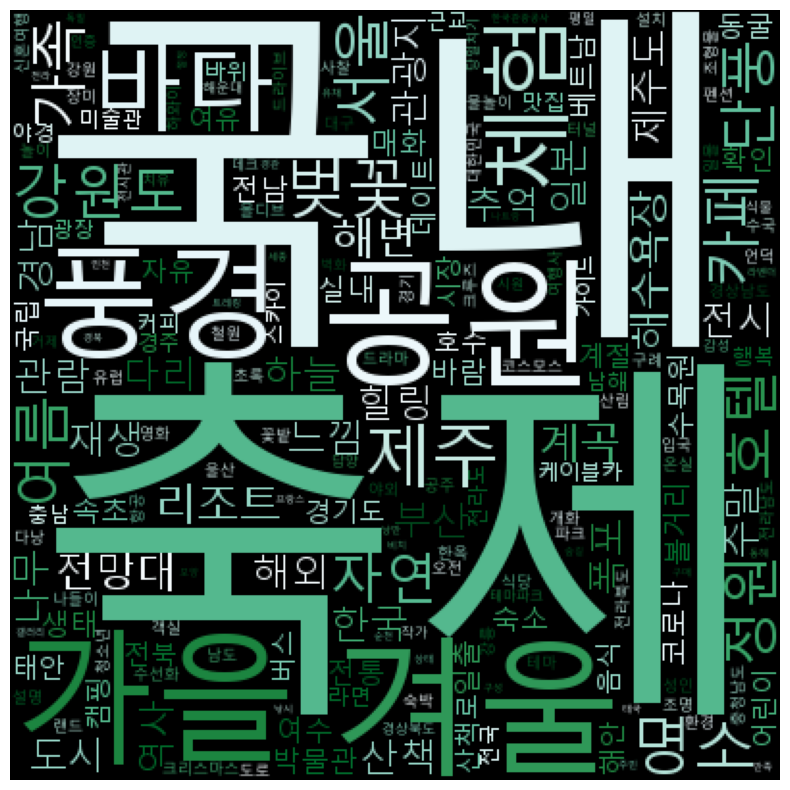

In [24]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBu': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [26]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'국내': 277,
 '축제': 195,
 '겨울': 180,
 '가을': 162,
 '제주': 80,
 '바다': 79,
 '해외': 76,
 '여름': 75,
 '서울': 75,
 '강원도': 74,
 '공원': 72,
 '명소': 66,
 '가족': 61,
 '제주도': 60,
 '벚꽃': 58,
 '대구': 56,
 '여행사': 52,
 '초록': 49,
 '일자': 48,
 '전라도': 47,
 '전남': 47,
 '일본': 46,
 '단풍': 46,
 '부산': 44,
 '관광지': 44,
 '전북': 42,
 '양훈': 42,
 '경남': 41,
 '태안': 38,
 '코로나': 37,
 '전국': 35,
 '여수': 31,
 '리조트': 31,
 '근교': 31,
 '해수욕장': 31,
 '베트남': 31,
 '한국': 31,
 '충남': 30,
 '다리': 30,
 '하동': 30,
 '체험': 30,
 '힐링': 29,
 '경주': 29,
 '테마': 28,
 '풍경': 28,
 '호텔': 27,
 '삼성': 27,
 '드라이브': 27,
 '경기도': 27,
 '볼거리': 26,
 '수목원': 26,
 '남해': 26,
 '순수': 25,
 '도시': 25,
 '주말': 25,
 '데이트': 25,
 '개화': 24,
 '개장': 24,
 '속초': 24,
 '강릉': 24,
 '담양': 23,
 '신혼': 23,
 '계절': 22,
 '연말': 22,
 '당일치기': 22,
 '자연': 22,
 '매화': 21,
 '계곡': 21,
 '버스': 21,
 '날짜': 21,
 '추석': 20,
 '수국': 20,
 '당일': 19,
 '실내': 19,
 '생태': 19,
 '나들이': 19,
 '경북': 19,
 '철원': 18,
 '연휴': 18,
 '고석정': 17,
 '해외여행': 17,
 '하늘': 17,
 '뮤지엄': 17,
 '정원': 17,
 '맛집': 17,
 '공주': 17,
 '일출': 17,
 '관람': 17,
 '순위'

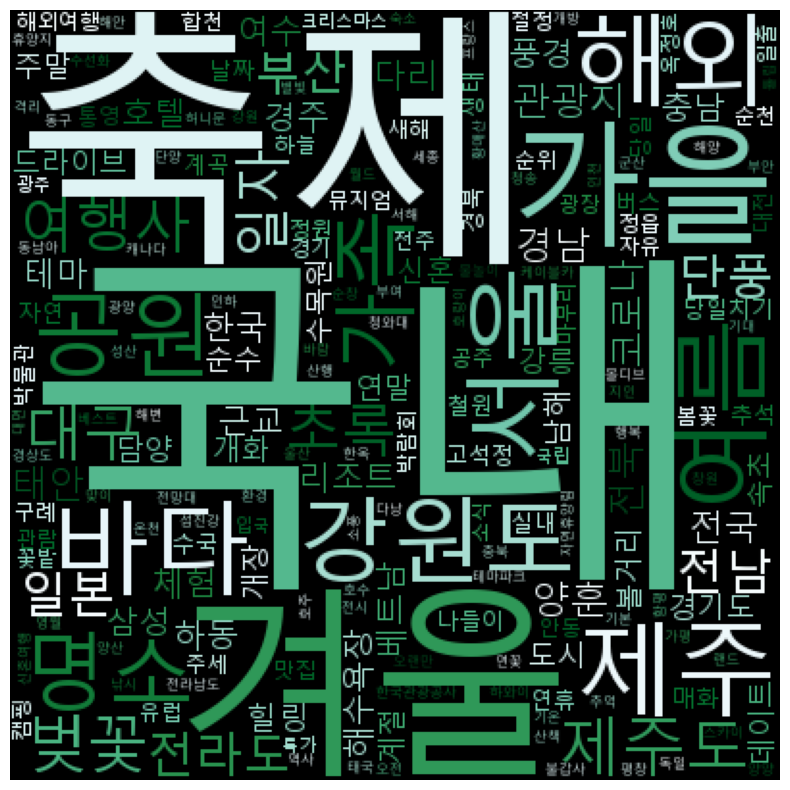

In [27]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [28]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'국내': 243,
 '가을': 130,
 '겨울': 119,
 '축제': 112,
 '제주': 71,
 '해외': 65,
 '명소': 57,
 '공원': 51,
 '강원도': 50,
 '여름': 46,
 '서울': 45,
 '전남': 40,
 '경남': 36,
 '가족': 36,
 '데이트': 32,
 '전라도': 32,
 '대구': 31,
 '단풍': 30,
 '전북': 29,
 '신혼여행': 29,
 '벚꽃': 28,
 '부산': 28,
 '제주도': 26,
 '해수욕장': 25,
 '근교': 24,
 '삼성': 23,
 '여행사': 22,
 '충남': 21,
 '체험': 20,
 '베스트': 20,
 '일본': 19,
 '수목원': 18,
 '태안': 18,
 '속초': 18,
 '여수': 18,
 '드라이브': 18,
 '실내': 18,
 '경기도': 17,
 '전국': 17,
 '몽골': 17,
 '순위': 17,
 '관광지': 17,
 '바다': 17,
 '연말': 16,
 '베트남': 16,
 '담양': 16,
 '호텔': 15,
 '경북': 15,
 '대전': 15,
 '철원': 15,
 '나들이': 14,
 '남해': 14,
 '당일치기': 14,
 '박물관': 14,
 '볼거리': 14,
 '리조트': 13,
 '생태': 13,
 '일출': 13,
 '충북': 13,
 '경주': 13,
 '주말': 13,
 '계곡': 13,
 '숙소': 12,
 '동남아': 12,
 '수국': 12,
 '구례': 12,
 '세종': 12,
 '다리': 12,
 '맛집': 12,
 '힐링': 12,
 '자유': 12,
 '해외여행': 12,
 '카페': 12,
 '개화': 12,
 '광양': 11,
 '공주': 11,
 '몰디브': 11,
 '야경': 11,
 '울산': 10,
 '매화': 10,
 '합천': 10,
 '거제': 10,
 '유럽': 10,
 '지민': 10,
 '경상도': 10,
 '모음': 9,
 '강릉': 9,
 '스카이': 9,
 '크

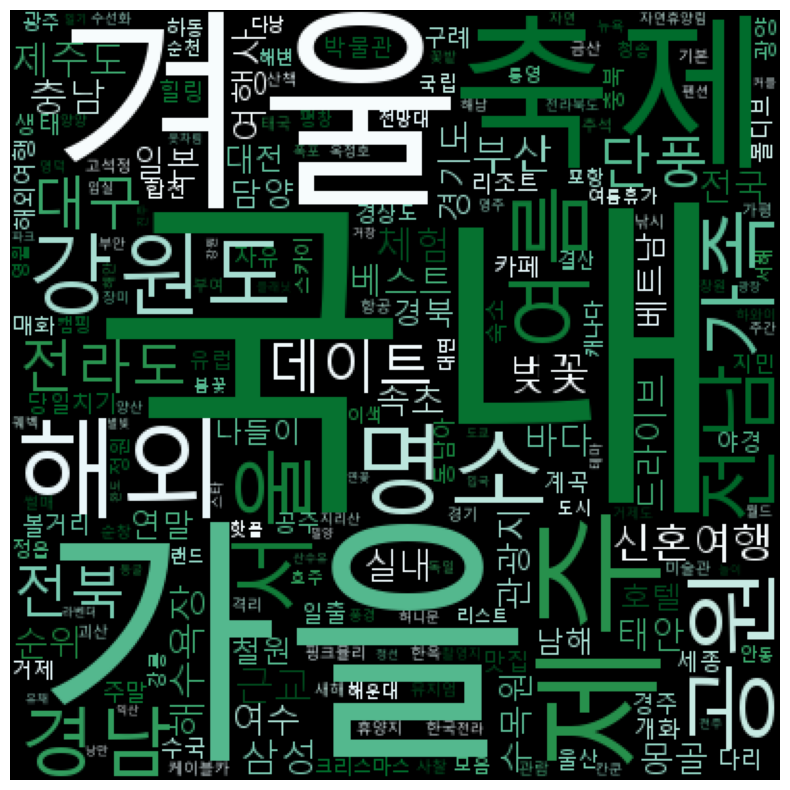

In [29]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Spring WordCloud]

In [30]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = spring_word_counts.set_index('word').to_dict()['count']
dic_word

{'벚꽃': 404,
 '매화': 249,
 '축제': 193,
 '풍경': 137,
 '공원': 132,
 '수선화': 124,
 '명소': 123,
 '체험': 122,
 '개화': 102,
 '구례': 100,
 '카페': 98,
 '국내': 89,
 '바다': 87,
 '산수유': 77,
 '서울': 75,
 '가족': 75,
 '나무': 69,
 '홍매': 68,
 '제주': 65,
 '벽화': 62,
 '트레킹': 62,
 '전남': 59,
 '자연': 59,
 '일본': 58,
 '남도': 58,
 '봄꽃': 58,
 '고려': 55,
 '광양': 53,
 '역사': 53,
 '주말': 51,
 '전시': 51,
 '전라': 51,
 '한국': 50,
 '포항': 50,
 '경기도': 49,
 '랜드': 49,
 '횡성': 48,
 '통영': 48,
 '국립': 48,
 '제주도': 47,
 '순천': 46,
 '전망대': 46,
 '생태': 45,
 '금둔사': 44,
 '산책': 44,
 '전라도': 44,
 '서산': 43,
 '여수': 43,
 '선도': 43,
 '정선': 42,
 '힐링': 41,
 '관광지': 41,
 '산책로': 41,
 '동물': 41,
 '선암사': 41,
 '한국관광공사': 39,
 '만개': 39,
 '볼거리': 39,
 '식물원': 36,
 '가옥': 36,
 '유채': 36,
 '치유': 36,
 '관람': 34,
 '조형물': 34,
 '박물관': 34,
 '추억': 34,
 '곤충': 33,
 '나들이': 33,
 '진달래': 32,
 '골프': 32,
 '강원': 31,
 '전통': 30,
 '낚시': 30,
 '전시관': 30,
 '산림': 29,
 '바람': 29,
 '하늘': 29,
 '전북': 29,
 '익산': 29,
 '울진': 28,
 '사찰': 28,
 '순창': 28,
 '확인': 28,
 '재생': 28,
 '강원도': 27,
 '미술관': 27,
 '전국': 27,
 '대관령': 2

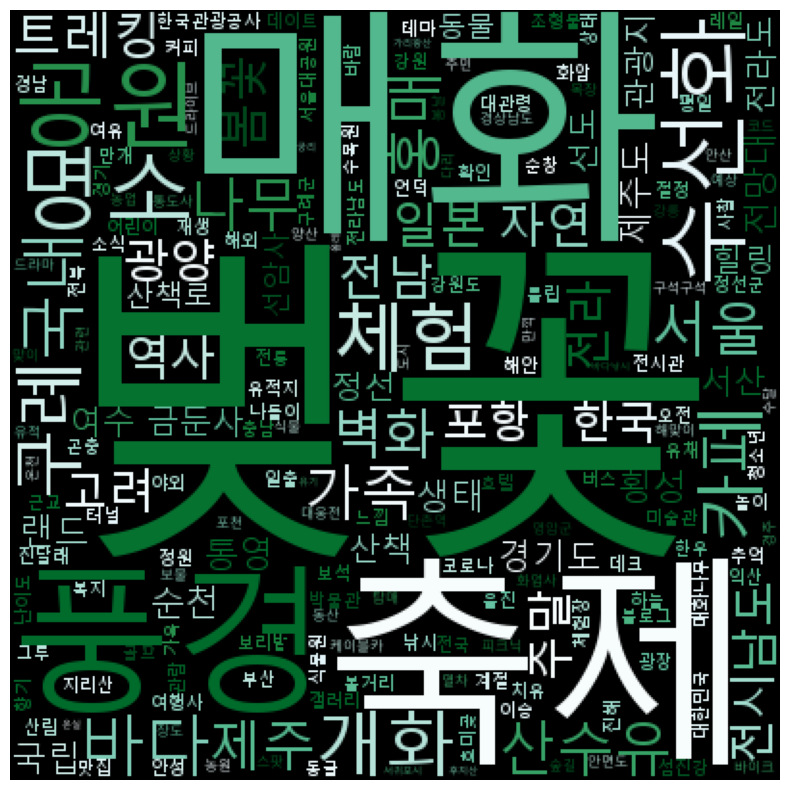

In [31]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Summer WordCloud]

In [32]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = summer_word_counts.set_index('word').to_dict()['count']
dic_word

{'여름': 349,
 '해수욕장': 266,
 '바다': 217,
 '해변': 214,
 '축제': 213,
 '국내': 204,
 '계곡': 201,
 '제주': 157,
 '체험': 154,
 '풍경': 149,
 '동굴': 130,
 '강원도': 119,
 '공원': 98,
 '카페': 91,
 '관광지': 89,
 '가족': 87,
 '다낭': 86,
 '자연': 84,
 '물놀이': 82,
 '리조트': 82,
 '전망대': 78,
 '명소': 77,
 '시원': 76,
 '폭포': 75,
 '해안': 72,
 '해외': 71,
 '금산': 70,
 '호텔': 69,
 '도시': 69,
 '힐링': 69,
 '베트남': 69,
 '캠핑': 68,
 '강릉': 68,
 '코로나': 67,
 '라벤더': 66,
 '산책': 64,
 '완도': 61,
 '하동': 60,
 '숙소': 60,
 '수국': 59,
 '영화': 59,
 '커피': 57,
 '서울': 57,
 '놀이터': 56,
 '바위': 55,
 '격포': 53,
 '검사': 53,
 '산책로': 53,
 '경기도': 52,
 '한국': 52,
 '하늘': 51,
 '드라마': 50,
 '반려동물': 50,
 '재생': 49,
 '입국': 49,
 '격리': 47,
 '제주도': 47,
 '느낌': 47,
 '전라남도': 46,
 '모래': 46,
 '호주': 46,
 '스카이': 45,
 '몰디브': 45,
 '뉴욕': 45,
 '정원': 44,
 '몽골': 44,
 '장미': 44,
 '속초': 44,
 '음식': 44,
 '개장': 43,
 '바람': 43,
 '사구': 43,
 '나무': 43,
 '전남': 43,
 '주말': 43,
 '남해': 42,
 '연꽃': 42,
 '전라도': 42,
 '곤충': 42,
 '자유': 42,
 '라면': 41,
 '놀이': 41,
 '부안': 41,
 '역사': 41,
 '어린이': 41,
 '재즈': 41,
 '벚꽃': 41,
 '접종': 4

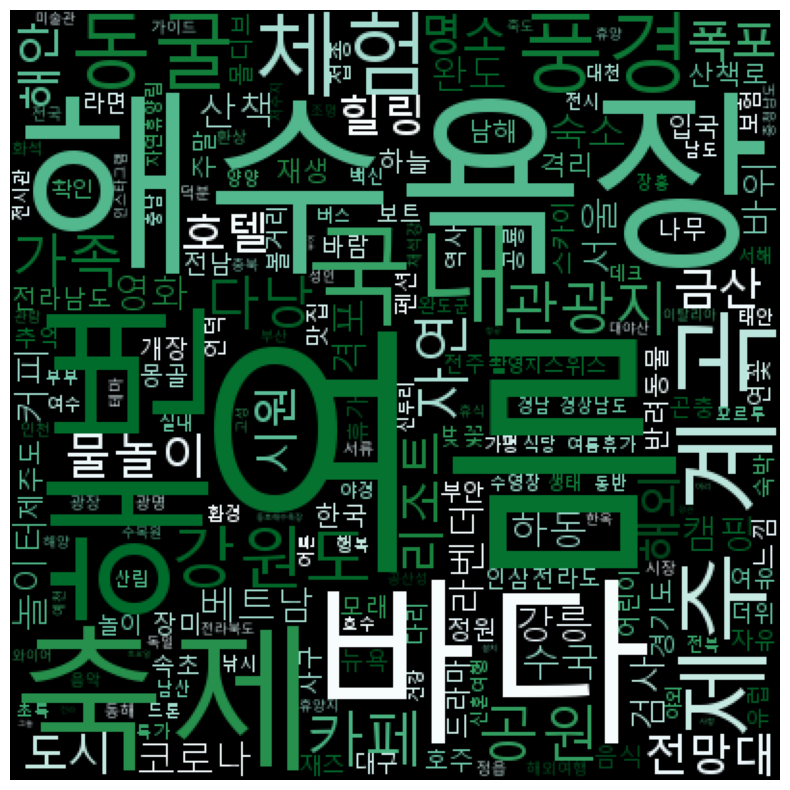

In [33]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Autumn WordCloud]

In [34]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = autumn_word_counts.set_index('word').to_dict()['count']
dic_word

{'가을': 733,
 '축제': 481,
 '단풍': 362,
 '공원': 224,
 '국내': 207,
 '서울': 176,
 '풍경': 161,
 '체험': 128,
 '명소': 119,
 '코스모스': 117,
 '강원도': 108,
 '꽃밭': 104,
 '정원': 104,
 '경남': 93,
 '전남': 89,
 '철원': 86,
 '폭포': 85,
 '국화': 80,
 '고석정': 80,
 '강천사': 80,
 '하늘': 79,
 '공주': 79,
 '나무': 72,
 '전라도': 71,
 '절정': 67,
 '함평': 64,
 '어린이': 63,
 '박물관': 62,
 '가족': 61,
 '핑크뮬리': 59,
 '상사화': 58,
 '전망대': 58,
 '재생': 58,
 '백제': 58,
 '충남': 57,
 '바람': 56,
 '전시': 56,
 '제주': 56,
 '산책': 55,
 '경기': 54,
 '가이드': 54,
 '퀘벡': 53,
 '행복': 53,
 '다리': 52,
 '역사': 52,
 '바다': 51,
 '의령': 50,
 '도시': 48,
 '볼거리': 48,
 '경기도': 48,
 '힐링': 48,
 '핑크': 47,
 '추억': 46,
 '댑싸리': 45,
 '주말': 44,
 '메밀꽃': 44,
 '해남': 43,
 '관람': 43,
 '카페': 43,
 '자연': 43,
 '사찰': 42,
 '관광지': 42,
 '전라북도': 42,
 '공산성': 42,
 '억새': 42,
 '추석': 41,
 '수목원': 41,
 '사과': 41,
 '전국': 41,
 '나들이': 40,
 '광장': 40,
 '경상남도': 39,
 '카메라': 38,
 '청소년': 38,
 '캠핑': 37,
 '느낌': 37,
 '해바라기': 37,
 '대전': 37,
 '드라이브': 36,
 '한옥': 36,
 '한국': 36,
 '강원': 36,
 '근교': 36,
 '순창': 35,
 '생태': 35,
 '캐나다': 35,
 '감사': 34

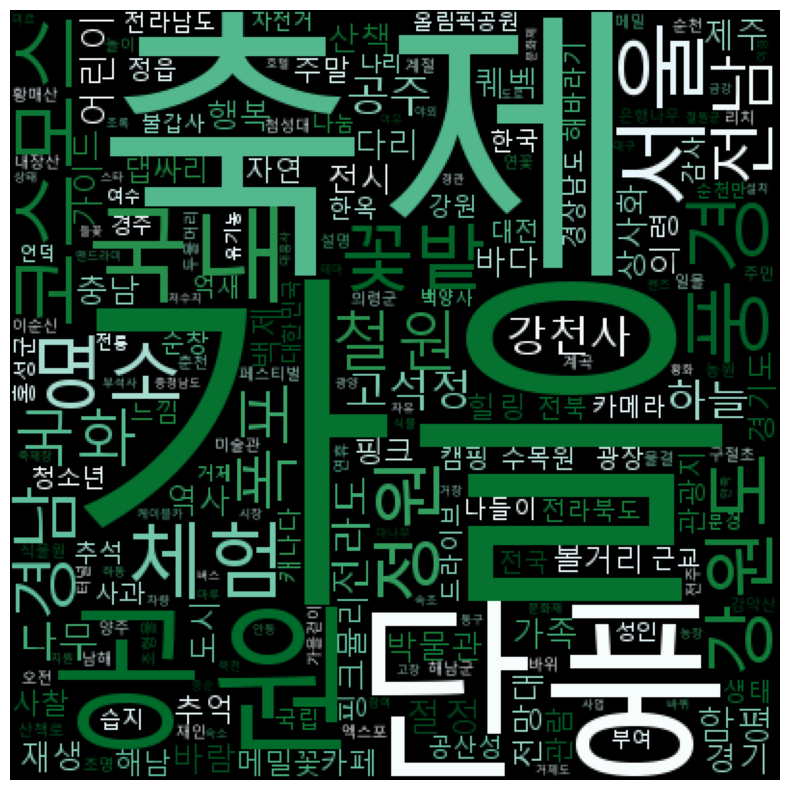

In [35]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Winter WordCloud]

In [36]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = winter_word_counts.set_index('word').to_dict()['count']
dic_word

{'겨울': 540,
 '국내': 258,
 '축제': 189,
 '체험': 154,
 '크리스마스': 150,
 '바다': 116,
 '강원도': 110,
 '제주': 107,
 '나트랑': 101,
 '명소': 100,
 '풍경': 100,
 '지민': 95,
 '가족': 92,
 '사이판': 89,
 '카페': 87,
 '일본': 85,
 '공원': 82,
 '도시': 74,
 '해외': 69,
 '제주도': 67,
 '마켓': 64,
 '브루나이': 60,
 '강릉': 59,
 '데이트': 57,
 '해운대': 56,
 '베트남': 55,
 '전망대': 55,
 '호텔': 55,
 '와인': 54,
 '태안': 54,
 '자연': 54,
 '실내': 53,
 '썰매': 53,
 '볼거리': 52,
 '관람': 52,
 '힐링': 52,
 '서울': 52,
 '부산': 52,
 '담양': 51,
 '조명': 51,
 '유럽': 51,
 '수목원': 50,
 '해변': 50,
 '랜드': 48,
 '느낌': 46,
 '역사': 45,
 '가이드': 45,
 '광장': 44,
 '거제': 43,
 '연말': 43,
 '추억': 42,
 '펜션': 41,
 '한국': 41,
 '리조트': 41,
 '해안': 41,
 '전통': 41,
 '한라': 41,
 '여수': 41,
 '케이블카': 40,
 '파크': 39,
 '해수욕장': 39,
 '어린이': 38,
 '태안군': 38,
 '야경': 38,
 '자유': 38,
 '캠핑': 38,
 '커피': 38,
 '영덕': 37,
 '스카이': 37,
 '근교': 37,
 '나무': 36,
 '조형물': 36,
 '안동': 36,
 '재생': 36,
 '박물관': 36,
 '프로방스': 35,
 '정동진': 34,
 '하멜': 34,
 '전남': 33,
 '주말': 33,
 '확인': 33,
 '철원': 33,
 '새해': 33,
 '전주': 33,
 '저수지': 32,
 '구매': 32,
 '음식': 32,
 '

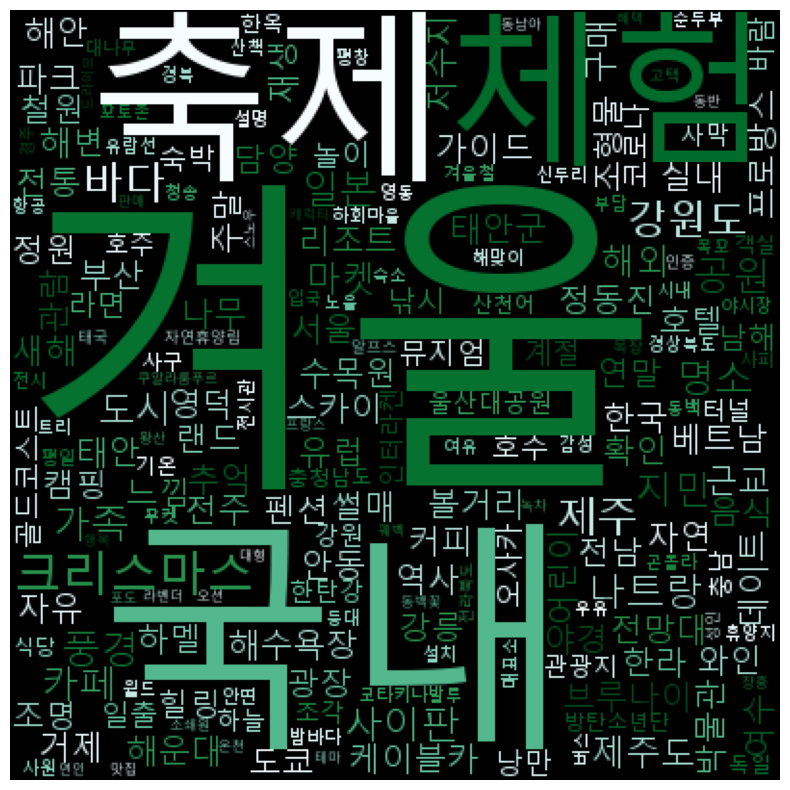

In [37]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기